# The Conundrum : 

When building machine learning models, we often tend to focus on the more glamorous aspects of machine learning, such as finding the best architecture and tuning hyperparameters, that we fail to recognize that our dataset is the lifeblood of our entire pipeline.

Current hardware for ML, such as TPUs and GPUs, are built with several hundred cores that enable them to massively parallelize machine learning workloads. This is a really great development, but in order to leverage this massive parallelism of such hardware, we need the right set of tools to enable us to fully utilize such high compute capabilities.

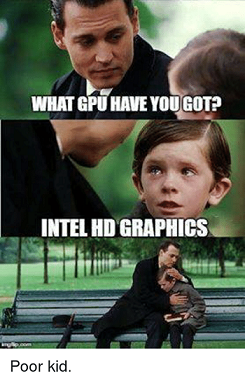 

In [1]:
%%capture
import os
for dirname, _, filename in os.walk("../input"):
  for files in filename:
    print(os.path.join(dirname, files))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
%matplotlib inline
import cv2
from tqdm import tqdm_notebook as tqdm

# Data Reading

In [3]:
train_data = pd.DataFrame(pd.read_csv("../input/plant-pathology-2020-fgvc7/train.csv"))
test_data = pd.DataFrame(pd.read_csv("../input/plant-pathology-2020-fgvc7/test.csv"))

In [4]:
train_data.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [5]:
print("Training data shape : = {}".format(train_data.shape))
print("Test data shape : = {}".format(test_data.shape))

Training data shape : = (1821, 5)
Test data shape : = (1821, 1)


In [6]:
image_folder_path = "../input/plant-pathology-2020-fgvc7/images/"

In [7]:
arr = train_data["image_id"]
train_images = [i for i in arr]

In [8]:
print(train_images[:5])

['Train_0', 'Train_1', 'Train_2', 'Train_3', 'Train_4']


In [9]:
def load_image(image_id) : 
  image_path = image_folder_path +image_id +".jpg"
  image = cv2.imread(image_path) 
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  return image

def resize(image):
  image = cv2.resize(image, (800, 800))
  return image

# Dataset Creation Techniques : 

Having efficient data pipelines is of paramount importance for any machine learning model.

## AVOID THIS !!

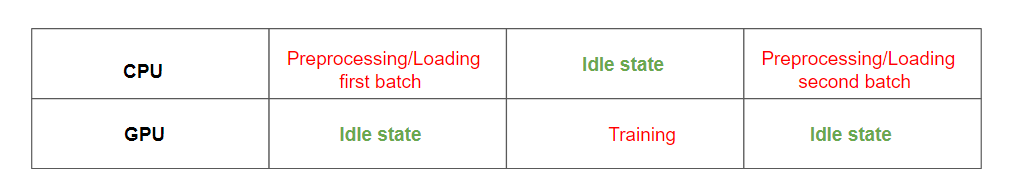

## Go for this : 

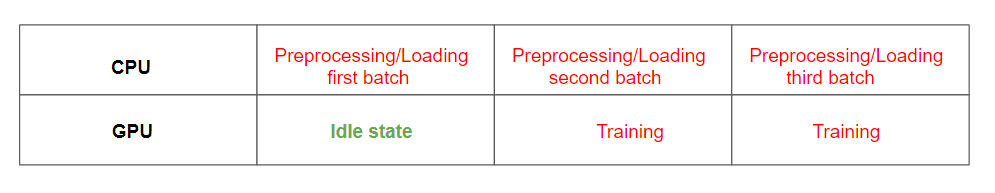

TensorFlow’s Dataset module **tf.data** can be used build efficient data pipelines. **tf_data** improves the performance by prefetching the next batch of data asynchronously so that GPU need not wait for the data. We can also parallelize the process of preprocessing and loading the dataset.



# Operations On Dataset : 

* `Batches:` Combines consecutive elements of the Dataset into a single batch. Useful when you want to train smaller batches of data to avoid out of memory errors.

* `Zip:` Creates a Dataset by zipping together datasets. Useful in scenarios where you have features and labels and you need to provide the pair of feature and label for training the model.

* `Map:` Used to transform the elements of the Dataset. Useful in cases where you want to transform your raw data before feeding into the model.

# tf.data API : 

The tf.data API was built with three major focal areas. These are:
* Performance
* Flexibility
* Ease of use

tf.data provides us with the tools to squeeze out every bit of performance from our hardware accelerators such as GPUs and TPUs. On the flexibility side, tf.data widens the spectrum of options in terms of the kinds of data we want to use, without having to rely on any external tools. 

Some common sources of data supported by tf.data are Python lists, TFRecords, CSV files, and several image formats such as JPG and PNG, text, etc. This means that we don’t need any extra tools such as Pandas to build our data pipeline — all of that functionality is built into tf.data. 

tf.data provides a plethora of methods to create datasets from numpy array, CSV files, tensors and so on..Some of the methods are listed below : 

* `from_tensor_slices:` It accepts single or multiple numpy arrays or tensors. Dataset created using this method will emit only one data at a time.

* `from_tensors:` It also accepts single or multiple numpy arrays or tensors. Dataset created using this method will emit all the data at once.

* `from_generator:` Creates a Dataset whose elements are generated by a function.

# Creation of Input Pipeline : 

## Step 1 : 

To create an input pipeline, you must start with a data source. For example, to construct a Dataset from data in memory, we can use `tf.data.Dataset.from_tensors()` or `tf.data.Dataset.from_tensor_slices()`. The difference between them has already been discussed above. 

Once we have a Dataset object, we can transform it into a new Dataset by chaining method calls on the `tf.data.Dataset` object.

In [10]:
def generate_label(image_id) : 
    """
    Returns the label of the image whose ID is provided as the argument.
    """
    instance = train_data[train_data["image_id"] == image_id] # capture that instance of the dataframe
    feature_value = instance[["healthy", "multiple_diseases", "rust", "scab"]] 
    label = np.array(feature_value)
    return label

In [11]:
def path(image_id_list) : 
    """
    Returns the paths of all the images whose ID we pass on as argument
    """
    images_path_cum_label = []
    for image_id in tqdm(image_id_list) : #tqdm for progress bar
        image_path = image_folder_path + image_id +".jpg"
        label = generate_label(image_id)
        
        path_cum_label = []
        path_cum_label.append(image_path)
        path_cum_label.append(label)
        
        images_path_cum_label.append(path_cum_label)
    return images_path_cum_label

In [12]:
images_path_cum_label = path(train_images)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [13]:
images_path_cum_label[:5]

[['../input/plant-pathology-2020-fgvc7/images/Train_0.jpg',
  array([[0, 0, 0, 1]])],
 ['../input/plant-pathology-2020-fgvc7/images/Train_1.jpg',
  array([[0, 1, 0, 0]])],
 ['../input/plant-pathology-2020-fgvc7/images/Train_2.jpg',
  array([[1, 0, 0, 0]])],
 ['../input/plant-pathology-2020-fgvc7/images/Train_3.jpg',
  array([[0, 0, 1, 0]])],
 ['../input/plant-pathology-2020-fgvc7/images/Train_4.jpg',
  array([[1, 0, 0, 0]])]]

Threfore, the image paths and the labels are successfully captured. We have used One-Hot style encoding for the corresponding labels.